<a href="https://colab.research.google.com/github/gr3g-z/TCC-PUCSP-CDIA/blob/main/SARIMA_StoreSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMA

## Extração de Dados e  Bibliotecas

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!pip install pmdarima

In [61]:
import pandas as pd
df_test  = pd.read_csv('/content/drive/MyDrive/store_sales/test.csv')
df_train  = pd.read_csv('/content/drive/MyDrive/store_sales/train.csv')
transactions  = pd.read_csv('/content/drive/MyDrive/store_sales/transactions.csv')
holiday  = pd.read_csv('/content/drive/MyDrive/store_sales/holidays_events.csv')
oil  = pd.read_csv('/content/drive/MyDrive/store_sales/oil.csv')
df_stores = pd.read_csv('/content/drive/MyDrive/store_sales/stores.csv')
sample = pd.read_csv('/content/drive/MyDrive/store_sales/sample_submission.csv')

In [62]:
# Libs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import prophet

## Engenharia de Features
* Juntando com (merge) as tabelas para utilizar os parametros de feriados, promocoes e preco da gasolina nas previsões.

In [63]:
df_train = df_train.merge(df_stores, on = 'store_nbr')
df_train = df_train.merge(oil, on ='date', how = 'left')
holiday = holiday.rename(columns = {'type': 'holiday_type'})
df_train = df_train.merge(holiday, on = 'date', how = 'left')

In [64]:
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [65]:
df_train.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64



We see that column oil price and holiday have lots of missing values. To handle that:

    Interpolate column oil price.
    A binary column for holiday, as 1-holiday and 0-no holiday.



In [66]:
df_train['dcoilwtico'] = df_train['dcoilwtico'].interpolate(limit_direction = 'both')
df_train.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico            0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [67]:
df_train['holiday'] = df_train['holiday_type'].notnull().astype(int)
df_train.sample(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred,holiday
1256593,651175,2014-01-02,3,LADIESWEAR,28.00000,0,Quito,Pichincha,D,8,95.140000,NaN,NaN,NaN,NaN,NaN,0
554539,2413132,2016-09-19,18,CLEANING,0.00000,0,Quito,Pichincha,B,16,43.340000,NaN,NaN,NaN,NaN,NaN,0
152154,2079684,2016-03-16,11,MEATS,672.27496,0,Cayambe,Pichincha,B,6,38.430000,NaN,NaN,NaN,NaN,NaN,0
2081257,2389081,2016-09-05,42,GROCERY II,23.00000,0,Cuenca,Azuay,D,2,44.758000,NaN,NaN,NaN,NaN,NaN,0
2259820,2863192,2017-05-30,45,GROCERY II,90.00000,0,Quito,Pichincha,A,11,49.630000,NaN,NaN,NaN,NaN,NaN,0
1035741,943275,2014-06-15,26,BEVERAGES,656.00000,0,Guayaquil,Guayas,D,10,107.506567,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Suiza,False,1
2503400,783770,2014-03-17,5,LAWN AND GARDEN,0.00000,0,Santo Domingo,Santo Domingo de los Tsachilas,D,4,98.430000,NaN,NaN,NaN,NaN,NaN,0
927897,1221201,2014-11-18,24,BEVERAGES,3332.00000,1,Guayaquil,Guayas,D,1,74.550000,NaN,NaN,NaN,NaN,NaN,0
2302765,2146873,2016-04-22,46,PERSONAL CARE,1039.00000,5,Quito,Pichincha,A,14,42.760000,Event,National,Ecuador,Terremoto Manabi+6,False,1
1777521,1284072,2014-12-23,38,DELI,206.80600,1,Loja,Loja,D,4,56.780000,Additional,National,Ecuador,Navidad-2,False,1


In [68]:
df_train['date']= pd.to_datetime(df_train['date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  holiday_type  object        
 12  locale        object        
 13  locale_name   object        
 14  description   object        
 15  transferred   object        
 16  holiday       int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(9)
memory usage: 396.1+ MB


In [69]:
# create new columns 'month' 'year'
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year

In [70]:
df_train.duplicated().any()

False

In [71]:
df_test.duplicated().any()

False

In [72]:
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred,holiday,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017


In [73]:
df_train = df_train.drop(['cluster'],axis=1)

* Dataframe (df_clusterizado) com clusters produzidos por K-Means.

In [74]:
# Carregar o DataFrame do arquivo pickle
df_clusterizado = pd.read_pickle('/content/drive/MyDrive/store_sales/df_clusterizado.pkl')
# Renomear a coluna 'A' para 'Nova_Coluna'
df_clusterizado = df_clusterizado.rename(columns={'loja': 'store_nbr'})
df_clusterizado

,store_nbr,Soma vendas totais,Contagem vendas totais,Media por venda,Dias com dados,Media do faturamento por dia,Media de vendas por dia,cluster
0,1,1.414501e+07,2553963,5.538456,1694,8350.066629,1507.652302,0
1,2,2.155739e+07,3219901,6.695047,1694,12725.731195,1900.768005,2
2,3,5.048191e+07,5366350,9.407122,1695,29782.837867,3165.988201,1
3,4,1.890970e+07,2519007,7.506807,1695,11156.165416,1486.139823,0
4,5,1.559240e+07,2347877,6.641065,1695,9199.058745,1385.178171,0
5,6,2.518368e+07,3065896,8.214134,1695,14857.628317,1808.788201,2
6,7,2.695205e+07,2995993,8.996032,1695,15900.914208,1767.547493,2
7,8,3.049429e+07,4637971,6.574920,1695,17990.729751,2736.266077,2
8,9,2.640944e+07,3516162,7.510872,1695,15580.791189,2074.431858,2
9,10,9.613906e+06,1652493,5.817819,1695,5671.920788,974.922124,0


In [75]:
# Renomeando a coluna "store_nbr" do df_clusterizado para evitar conflitos
df_clusterizado.rename(columns={"store_nbr": "store_nbr_cluster"}, inplace=True)
# Mesclando os dataframes com base na coluna "store_nbr"
df_train = pd.merge(df_train, df_clusterizado[['store_nbr_cluster', 'cluster']], left_on='store_nbr', right_on='store_nbr_cluster', how='left')
# Removendo a coluna adicional "store_nbr_cluster" após a mesclagem, se desejar
df_train.drop(columns=['store_nbr_cluster'], inplace=True)

In [76]:
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,type,dcoilwtico,holiday_type,locale,locale_name,description,transferred,holiday,month,year,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,2
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,2
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,2
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,1,8,2017,2


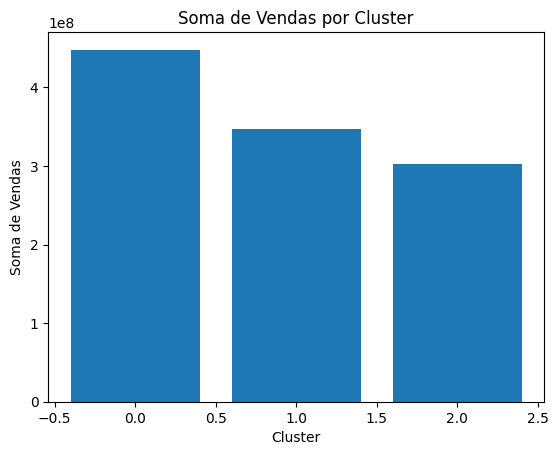

In [77]:
sales_sum_by_type = df_train.groupby('cluster')['sales'].sum()
plt.bar(sales_sum_by_type.index, sales_sum_by_type.values)
plt.xlabel('Cluster')
plt.ylabel('Soma de Vendas')
plt.title('Soma de Vendas por Cluster')
plt.show()

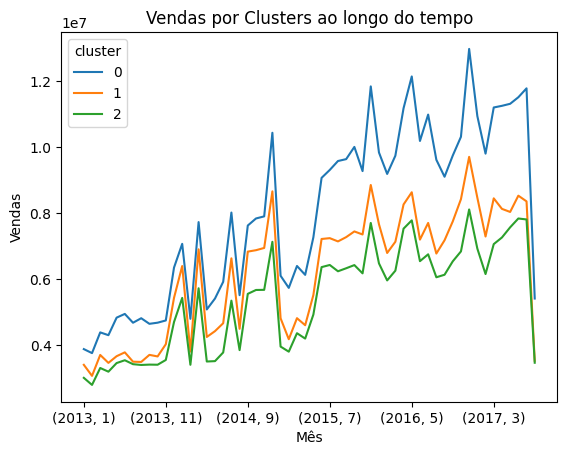

In [78]:
#Agrupar por mes e ano
monthly_sales_by_type = df_train.groupby(['year','month', 'cluster'])['sales'].sum()
pivot_df = monthly_sales_by_type.unstack(level='cluster')
pivot_df.plot()
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Vendas por Clusters ao longo do tempo')
plt.show()

In [79]:
# Criando um dicionário para armazenar os dataframes separados por cluster
df_train_clusters = {}
# Agrupando o dataframe df_train pela coluna "cluster"
grouped = df_train.groupby('cluster')
# Iterando sobre os grupos e armazenando em um dicionário
for cluster, group in grouped:
    df_train_clusters[cluster] = group

df_pqn = df_train_clusters[0]
df_gnd = df_train_clusters[1]
df_med = df_train_clusters[2]

In [80]:
df_pqn.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,dcoilwtico,holiday_type,locale,locale_name,description,transferred,holiday,month,year,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,93.14,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,0


In [81]:
df_gnd.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,dcoilwtico,holiday_type,locale,locale_name,description,transferred,holiday,month,year,cluster
1244364,726,2013-01-01,3,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,48.910294,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1
1244365,727,2013-01-01,3,BABY CARE,0.0,0,Quito,Pichincha,D,50.250588,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1
1244366,728,2013-01-01,3,BEAUTY,0.0,0,Quito,Pichincha,D,51.590882,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1
1244367,729,2013-01-01,3,BEVERAGES,0.0,0,Quito,Pichincha,D,52.931176,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1
1244368,730,2013-01-01,3,BOOKS,0.0,0,Quito,Pichincha,D,54.271471,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1


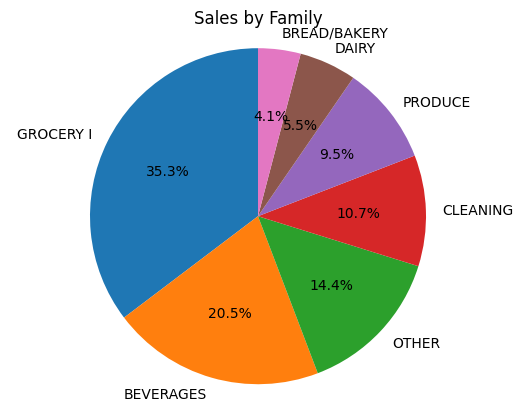

In [82]:
#Pie chart
# Group the data by family and calculate the total sales for each family
family_sales = df_pqn.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales['OTHER'] = family_sales.iloc[7:].sum()
family_sales = family_sales.sort_values(ascending = False).head(7)


plt.pie(family_sales, labels=family_sales.index, autopct='%1.1f%%', startangle=90)
plt.title('Sales by Family')
plt.axis('equal')
plt.show()

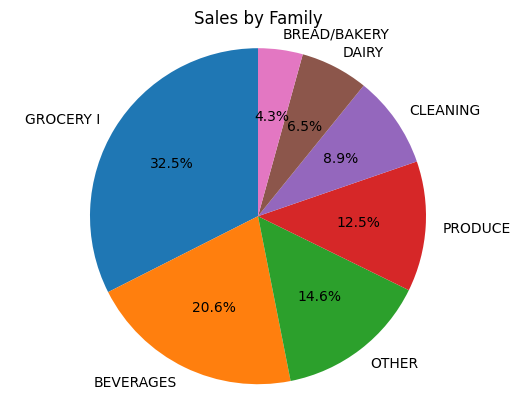

In [83]:
#Pie chart
# Group the data by family and calculate the total sales for each family
family_sales = df_med.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales['OTHER'] = family_sales.iloc[7:].sum()
family_sales = family_sales.sort_values(ascending = False).head(7)

plt.pie(family_sales, labels=family_sales.index, autopct='%1.1f%%', startangle=90)
plt.title('Sales by Family')
plt.axis('equal')
plt.show()

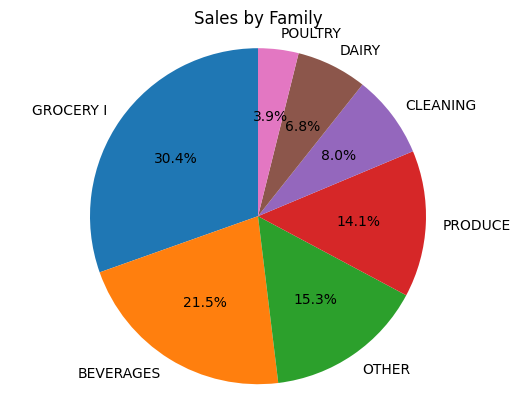

In [84]:
#Pie chart
# Group the data by family and calculate the total sales for each family
family_sales = df_gnd.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales['OTHER'] = family_sales.iloc[7:].sum()
family_sales = family_sales.sort_values(ascending = False).head(7)

plt.pie(family_sales, labels=family_sales.index, autopct='%1.1f%%', startangle=90)
plt.title('Sales by Family')
plt.axis('equal')
plt.show()

Efeito da promoção nas vendas.


In [85]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(df_pqn['onpromotion'], df_pqn['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.453715576158998
p-value: 0.0


In [86]:
correlation, p_value = pearsonr(df_med['onpromotion'], df_med['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.46730480427598997
p-value: 0.0


In [87]:
correlation, p_value = pearsonr(df_gnd['onpromotion'], df_gnd['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.48038960366981287
p-value: 0.0


Efeito dos feriados nas vendas.

In [88]:
correlation, p_value = pearsonr(df_pqn['holiday'], df_pqn['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.015339611421998358
p-value: 1.9927777202507395e-100


In [89]:
correlation, p_value = pearsonr(df_med['holiday'], df_med['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.014058550972830467
p-value: 1.808112115567331e-33


In [90]:
correlation, p_value = pearsonr(df_gnd['holiday'], df_gnd['sales'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.01895011704689797
p-value: 8.761085307875265e-33


There's a statistically significant correlation between holiday and sales, however the correlation coefficient is quite small. I think if I handle the data more carefully (since some holiday days are trasferred to other days) and put some weight to each holiday, the correlation can be stronger.

## Analise de lojas de pequeno porte

In [91]:
daily_sales = df_pqn.groupby('date')[['sales', 'holiday', 'onpromotion']].sum()
daily_sales['oil_price'] = df_pqn.groupby('date')['dcoilwtico'].mean()
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,1122,0,71.025147
2013-01-02,179611.130015,0,0,93.140000
2013-01-03,139894.862006,0,0,92.970000
2013-01-04,128652.032988,0,0,93.120000
2013-01-05,170832.361071,1122,0,93.140299


In [92]:
daily_sales.loc[daily_sales['holiday'] > 0, 'holiday'] = 1
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,2511.618999,1,0,71.025147
2013-01-02,179611.130015,0,0,93.140000
2013-01-03,139894.862006,0,0,92.970000
2013-01-04,128652.032988,0,0,93.120000
2013-01-05,170832.361071,1,0,93.140299


<Axes: >

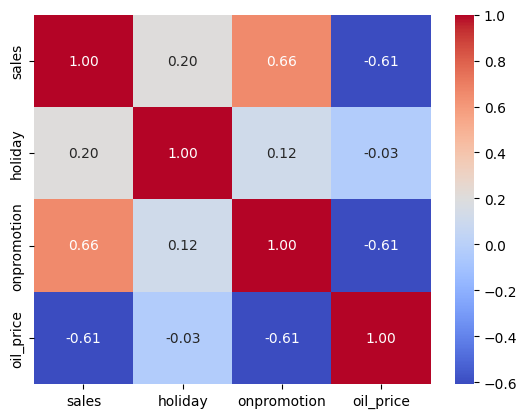

In [93]:
# Create a heat map
correlation_matrix = daily_sales.corr()

# Create a heat map of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

In [94]:
daily_sales = daily_sales.asfreq('D')
daily_sales[daily_sales.isnull().any(axis=1)]

,sales,holiday,onpromotion,oil_price
date,,,,
2013-12-25,NaN,NaN,NaN,NaN
2014-12-25,NaN,NaN,NaN,NaN
2015-12-25,NaN,NaN,NaN,NaN
2016-12-25,NaN,NaN,NaN,NaN


In [95]:
# Fill NaN value

daily_sales = daily_sales.asfreq('D')
daily_sales['sales'] = daily_sales['sales'].fillna(0)
daily_sales['holiday'] = daily_sales['holiday'].fillna(1)
daily_sales['onpromotion'] = daily_sales['onpromotion'].fillna(0)

# oil_price:
daily_sales['oil_price'] = daily_sales['oil_price'].interpolate(limit_direction = 'both')

daily_sales.isna().sum()

sales          0
holiday        0
onpromotion    0
oil_price      0
dtype: int64

In [96]:
monthly_sales = daily_sales.resample('M').sum()
monthly_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-31,3.890442e+06,3.0,0.0,2913.755147
2013-02-28,3.769315e+06,2.0,0.0,2672.080000
2013-03-31,4.395452e+06,1.0,0.0,2890.360000
2013-04-30,4.311434e+06,5.0,0.0,2754.140000
2013-05-31,4.841253e+06,4.0,0.0,2935.748250


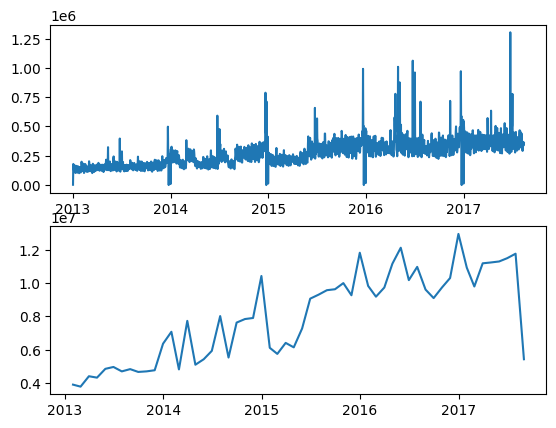

In [97]:
fig, axes = plt.subplots(2,1)
axes[0].plot(daily_sales['sales'])
axes[1].plot(monthly_sales['sales'])



The time series doesn't look very stationary, I guess there's a slight upward trend and seasonality.

For monthly data, there is an increasing trend in November and December, then followed by dips in January and Feburary next year.


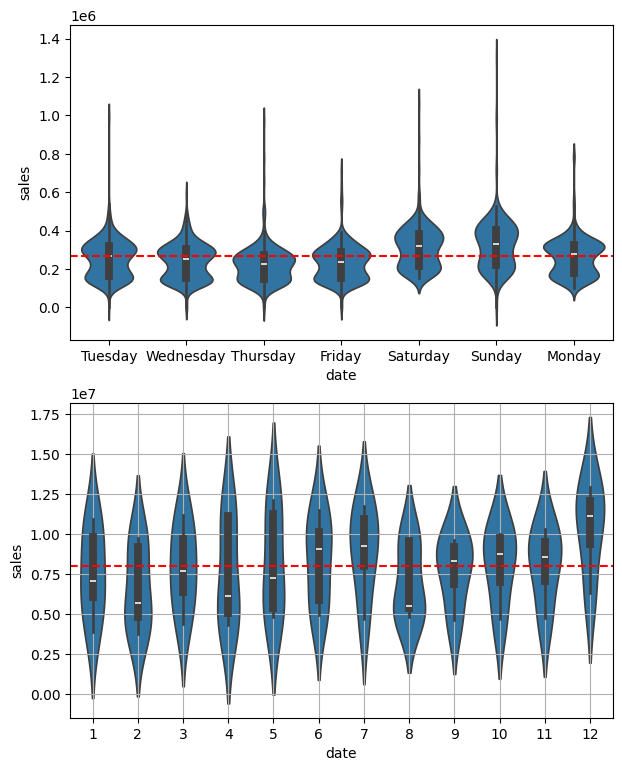

In [98]:
# violinplot of days of week and month to determine variance and range

days_of_week = daily_sales.index.day_name()

fig,axes = plt.subplots(2,1,figsize = (7, 9))
sns.violinplot(x=days_of_week, y=daily_sales['sales'], ax=axes[0])
axes[0].axhline(daily_sales['sales'].mean(), color='red', linestyle='--')

sns.violinplot(x=monthly_sales.index.month, y=monthly_sales['sales'], ax = axes[1])
axes[1].axhline(monthly_sales['sales'].mean(), color='red', linestyle='--')
plt.grid(True)
plt.show()



For days of the week, it is clear that Saturday and Sunday sales are highest and most varied, as the violins are longest and thinnest.

For monthly data, December have highest sales as expected, but July surprisingly comes in second.

But the differences are not as significant as I thought.


In [99]:
autocorr_values = daily_sales['sales'].autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.6410997704909872


The autocorrelation is quite noticeable, it can happen to have unit root.I check to see if it's I(1) or I(0)

In [100]:
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,) #call function adfuller
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    # display first 4 values with its name

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) #5th value is the CV

dftest(daily_sales.sales)

Test Statistic            -2.483020
p-value                    0.119661
Lags Used                 22.000000
Observations Used       1665.000000
Critical Value (1%)       -3.434284
Critical Value (5%)       -2.863277
Critical Value (10%)      -2.567695
dtype: float64


In [101]:
# define helper plot function for visualization

def plots(data, lags=None):
    plt.figure(figsize=(15, 4))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    raw.plot(data)
    plot_acf(data, lags=lags, ax=acf, zero=False)
    plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

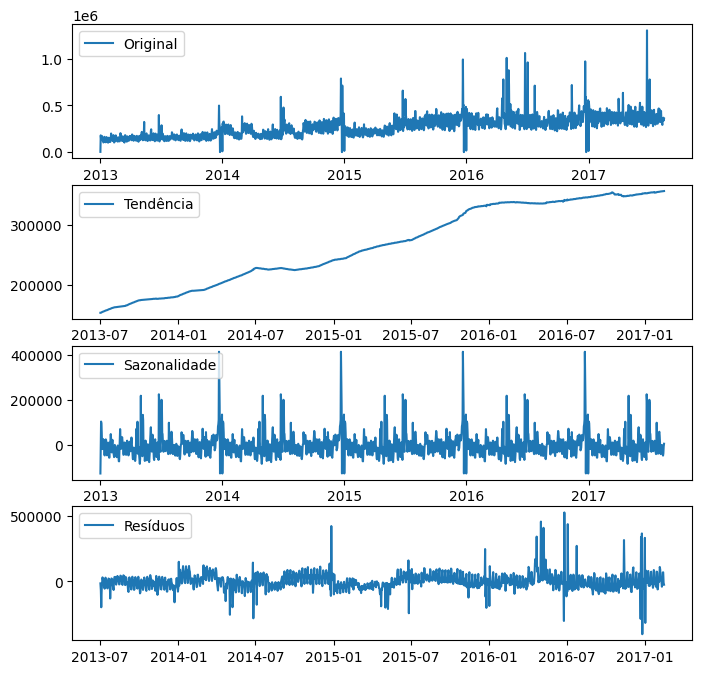

In [102]:
# Decomposição da série temporal para identificar tendências, sazonalidades e resíduos
decomposition = seasonal_decompose(daily_sales['sales'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualização da decomposição
plt.figure(figsize=(8, 8))
plt.subplot(411)
plt.plot(daily_sales['sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Resíduos')
plt.legend(loc='upper left')
plt.show()

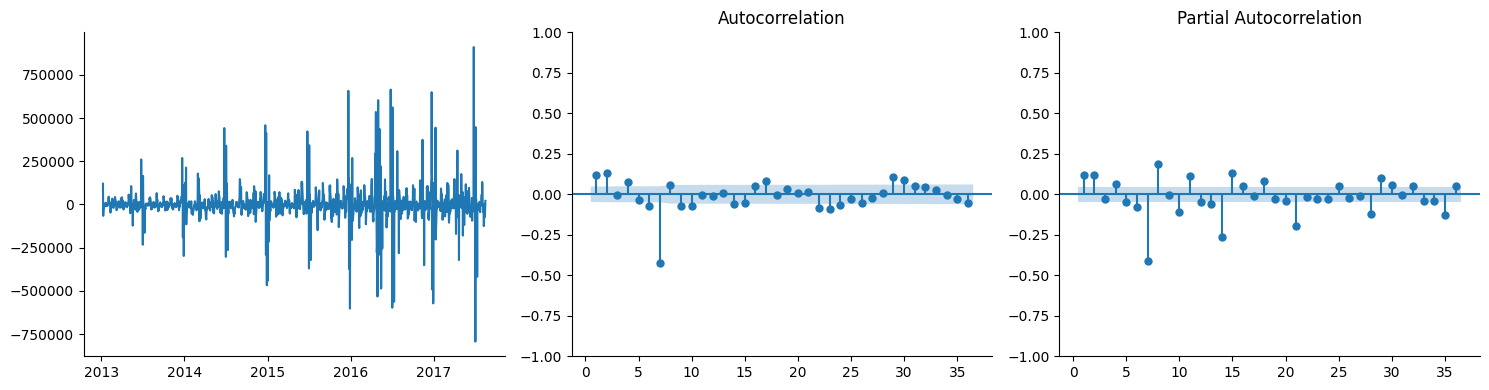

In [103]:
daily_sales['weekly_diff'] = daily_sales['sales'].diff(7)
plots(daily_sales.weekly_diff.dropna(), lags=36);

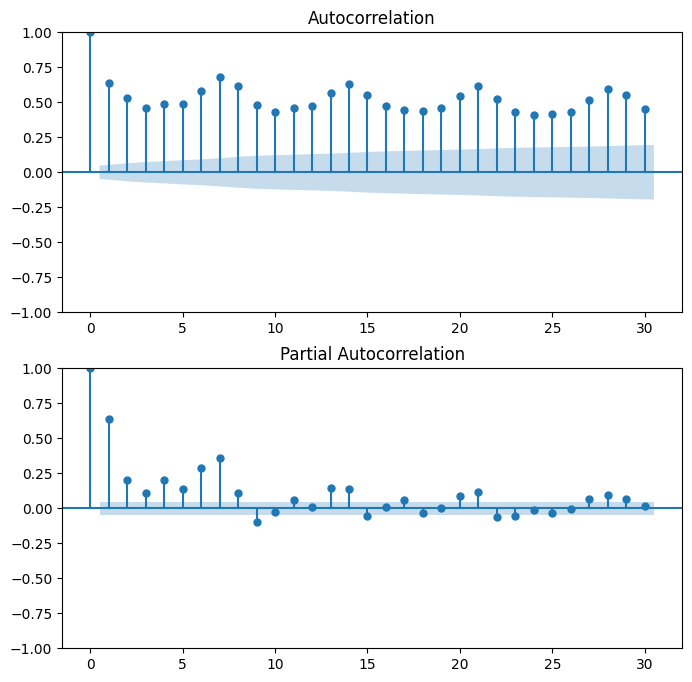

In [104]:
# Gráficos de Autocorrelação (ACF) e Autocorrelação Parcial (PACF)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plot_acf(daily_sales['sales'], ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(daily_sales['sales'], ax=plt.gca(), lags=30)
plt.show()

In [105]:
# Teste de Estacionariedade (ADF Test)
result = adfuller(daily_sales['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.4830199973898304
p-value: 0.11966059356788838
Critical Values:
   1%: -3.434283579780684
   5%: -2.863277451883613
   10%: -2.5676949772294817


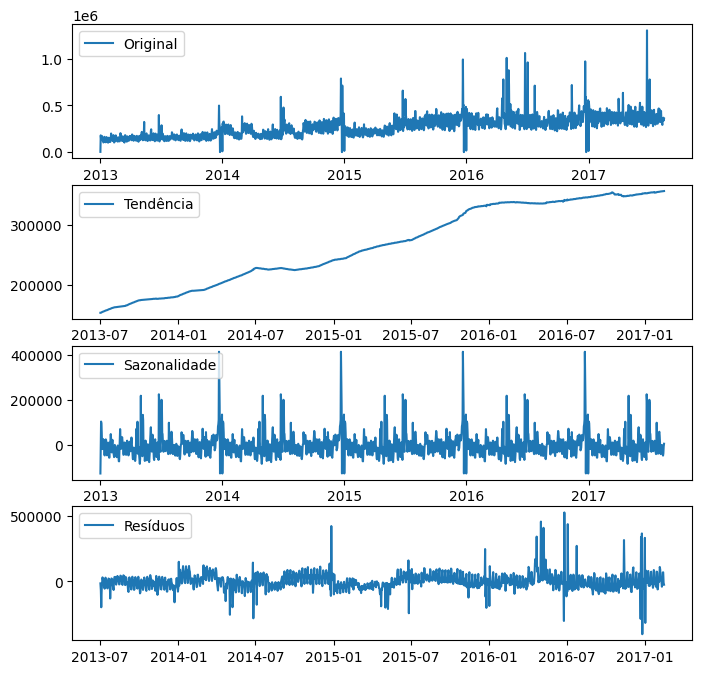

In [106]:
# Decomposição da série temporal para identificar tendências, sazonalidades e resíduos
decomposition = seasonal_decompose(daily_sales['sales'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualização da decomposição
plt.figure(figsize=(8, 8))
plt.subplot(411)
plt.plot(daily_sales['sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Resíduos')
plt.legend(loc='upper left')
plt.show()

In [107]:
dftest(daily_sales.weekly_diff.dropna())

Test Statistic         -1.244509e+01
p-value                 3.679770e-23
Lags Used               2.000000e+01
Observations Used       1.660000e+03
Critical Value (1%)    -3.434295e+00
Critical Value (5%)    -2.863283e+00
Critical Value (10%)   -2.567698e+00
dtype: float64


In [108]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(daily_sales['sales'], exog=daily_sales[['holiday', 'onpromotion', 'oil_price']],
                            start_p=2, start_q=0, max_p=3, max_q=2, m=7, # p,q = 1, 2, 3
                           start_P=0, seasonal=True, d=0, D=1, trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=43147.242, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=42799.528, Time=0.85 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=42515.377, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=43145.406, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=43129.419, Time=0.30 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=42809.106, Time=1.23 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=6.78 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=42577.464, Time=0.70 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=42468.643, Time=1.67 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=43113.130, Time=0.73 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Ti

In [109]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (2, 0, 2)
seasonal order:  (0, 1, 1, 7)


In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit SARIMA based on helper plots
sar = SARIMAX(daily_sales['sales'],
              exog=daily_sales[['holiday', 'onpromotion', 'oil_price']], #Exclude  'transactions'
                order=order,
                seasonal_order=seasonal_order, #(P, Q, D)
                trend='c').fit()
sar.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1688
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 7)   Log Likelihood              -20587.174
Date:                             Tue, 09 Apr 2024   AIC                          41194.347
Time:                                     21:02:24   BIC                          41248.619
Sample:                                 01-01-2013   HQIC                         41214.450
                                      - 08-15-2017                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    -122.8883    331.316     -0.371      0.711    -772.256     526.479
holiday      2.099e+04   4119.536      5.095      0.000    1.29e+04    2.91e+04
onpromotion    50.2288      0.857     58.631      0.000      48.550      51.908
oil_price     520.0830   1112.309      0.468      0.640   -1660.004    2700.170
ar.L1           0.1335      0.379      0.353      0.724      -0.609       0.876
ar.L2           0.6769      0.343      1.974      0.048       0.005       1.349
ma.L1           0.2326      0.382      0.608      0.543      -0.517       0.982
ma.L2          -0.3701      0.224     -1.655      0.098      -0.808       0.068
ma.S.L7        -0.8277      0.021    -40.372      0.000      -0.868      -0.787
sigma2       3.634e+09      0.104    3.5e+10      0.000    3.63e+09    3.63e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):             35564.55
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             1.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.55e+25. Standard errors may be unstable.
"""

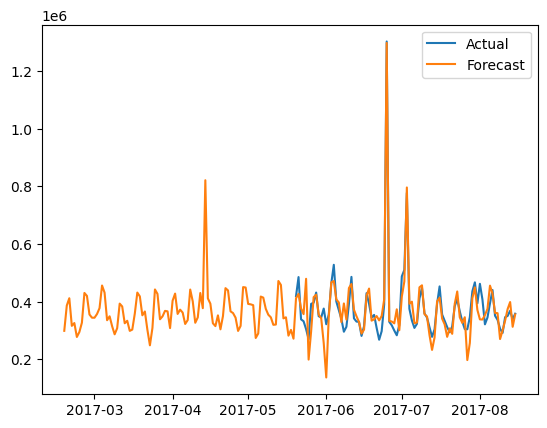

In [111]:
# Select the last 90 days of data for comparison
last_90_days = daily_sales.iloc[-60:]

# Extract the exogenous variables for the last 60 days
exog_data = last_90_days[['holiday', 'onpromotion', 'oil_price']]

# Get the forecast for the next 60 days, including exogenous variables
forecast = sar.get_prediction(start=last_90_days.index[0], end=last_90_days.index[-1], exog=exog_data)

# Extract the predicted values for the next 60 days
predicted_values = forecast.predicted_mean

# Plot the actual sales and predicted values
plt.plot(daily_sales[1600:]['sales'], label = 'Actual')
plt.plot(predicted_values.index, predicted_values, label='Forecast')
plt.legend()
plt.show()

In [112]:
daily_sales

,sales,holiday,onpromotion,oil_price,weekly_diff
date,,,,,
2013-01-01,2511.618999,1.0,0.0,71.025147,NaN
2013-01-02,179611.130015,0.0,0.0,93.140000,NaN
2013-01-03,139894.862006,0.0,0.0,92.970000,NaN
2013-01-04,128652.032988,0.0,0.0,93.120000,NaN
2013-01-05,170832.361071,1.0,0.0,93.140299,NaN
...,...,...,...,...,...
2017-08-11,346131.367031,1.0,7697.0,48.810000,1192.633024
2017-08-12,350405.882892,0.0,5077.0,48.500448,-43927.937117
2017-08-13,368353.726072,0.0,5845.0,47.899552,-72176.969937


In [113]:
daily_sales[1600:]['sales']

date
2017-05-20    419138.049976
2017-05-21    485388.141019
2017-05-22    338503.127921
2017-05-23    331974.517975
2017-05-24    304446.165974
                  ...      
2017-08-11    346131.367031
2017-08-12    350405.882892
2017-08-13    368353.726072
2017-08-14    338583.024999
2017-08-15    358240.862994
Freq: D, Name: sales, Length: 88, dtype: float64

## Analise de uma loja de Grande Porte

In [114]:
daily_sales = df_gnd.groupby('date')[['sales', 'holiday', 'onpromotion']].sum()
daily_sales['oil_price'] = df_pqn.groupby('date')['dcoilwtico'].mean()
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,0.000000,231,0,71.025147
2013-01-02,172162.455960,0,0,93.140000
2013-01-03,114747.209025,0,0,92.970000
2013-01-04,121740.534086,0,0,93.120000
2013-01-05,171797.564064,231,0,93.140299


In [115]:
daily_sales.loc[daily_sales['holiday'] > 0, 'holiday'] = 1
daily_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-01,0.000000,1,0,71.025147
2013-01-02,172162.455960,0,0,93.140000
2013-01-03,114747.209025,0,0,92.970000
2013-01-04,121740.534086,0,0,93.120000
2013-01-05,171797.564064,1,0,93.140299


<Axes: >

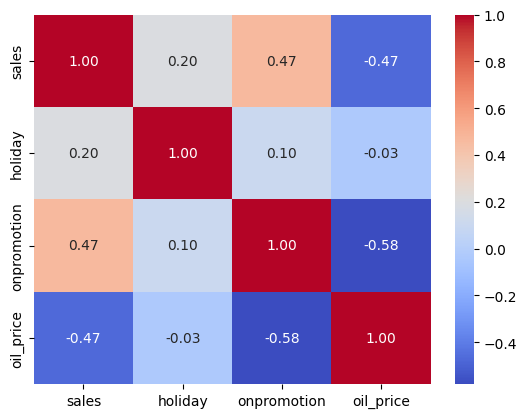

In [116]:
# Create a heat map
correlation_matrix = daily_sales.corr()

# Create a heat map of the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

In [117]:
daily_sales = daily_sales.asfreq('D')
daily_sales[daily_sales.isnull().any(axis=1)]

,sales,holiday,onpromotion,oil_price
date,,,,
2013-12-25,NaN,NaN,NaN,NaN
2014-12-25,NaN,NaN,NaN,NaN
2015-12-25,NaN,NaN,NaN,NaN
2016-12-25,NaN,NaN,NaN,NaN


In [118]:
# Fill NaN value

daily_sales = daily_sales.asfreq('D')
daily_sales['sales'] = daily_sales['sales'].fillna(0)
daily_sales['holiday'] = daily_sales['holiday'].fillna(1)
daily_sales['onpromotion'] = daily_sales['onpromotion'].fillna(0)

# oil_price:
daily_sales['oil_price'] = daily_sales['oil_price'].interpolate(limit_direction = 'both')

daily_sales.isna().sum()

sales          0
holiday        0
onpromotion    0
oil_price      0
dtype: int64

In [119]:
monthly_sales = daily_sales.resample('M').sum()
monthly_sales.head()

,sales,holiday,onpromotion,oil_price
date,,,,
2013-01-31,3.415349e+06,3.0,0.0,2913.755147
2013-02-28,3.081812e+06,2.0,0.0,2672.080000
2013-03-31,3.713824e+06,1.0,0.0,2890.360000
2013-04-30,3.473902e+06,5.0,0.0,2754.140000
2013-05-31,3.675757e+06,4.0,0.0,2935.748250


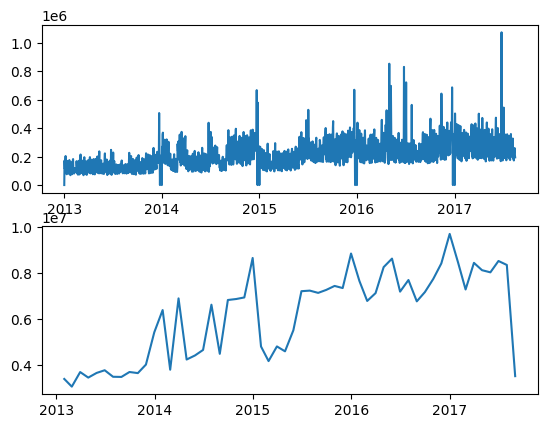

In [120]:
fig, axes = plt.subplots(2,1)
axes[0].plot(daily_sales['sales'])
axes[1].plot(monthly_sales['sales'])

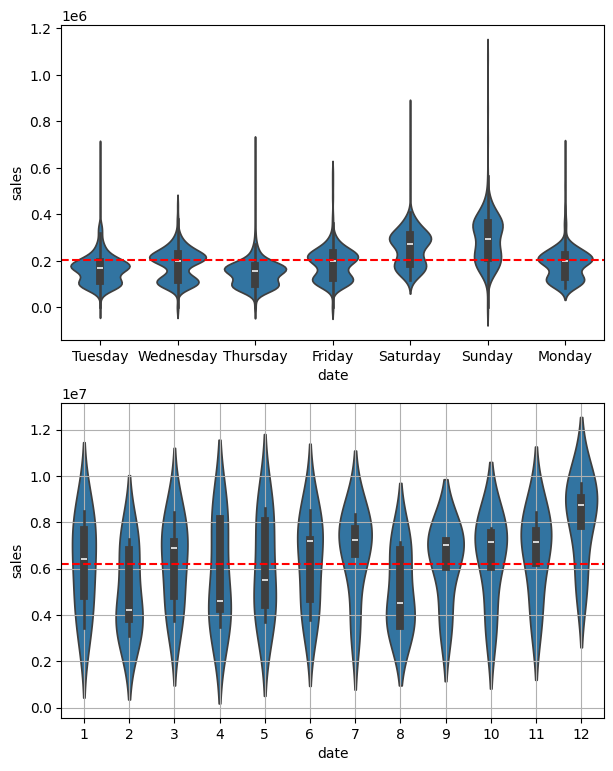

In [121]:
# violinplot of days of week and month to determine variance and range

days_of_week = daily_sales.index.day_name()

fig,axes = plt.subplots(2,1,figsize = (7, 9))
sns.violinplot(x=days_of_week, y=daily_sales['sales'], ax=axes[0])
axes[0].axhline(daily_sales['sales'].mean(), color='red', linestyle='--')

sns.violinplot(x=monthly_sales.index.month, y=monthly_sales['sales'], ax = axes[1])
axes[1].axhline(monthly_sales['sales'].mean(), color='red', linestyle='--')
plt.grid(True)
plt.show()

In [122]:
autocorr_values = daily_sales['sales'].autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.5408694505418813


In [123]:
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,) #call function adfuller
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    # display first 4 values with its name

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) #5th value is the CV

dftest(daily_sales.sales)

Test Statistic            -2.982416
p-value                    0.036570
Lags Used                 22.000000
Observations Used       1665.000000
Critical Value (1%)       -3.434284
Critical Value (5%)       -2.863277
Critical Value (10%)      -2.567695
dtype: float64


In [124]:
# define helper plot function for visualization

def plots(data, lags=None):
    plt.figure(figsize=(15, 4))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    raw.plot(data)
    plot_acf(data, lags=lags, ax=acf, zero=False)
    plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

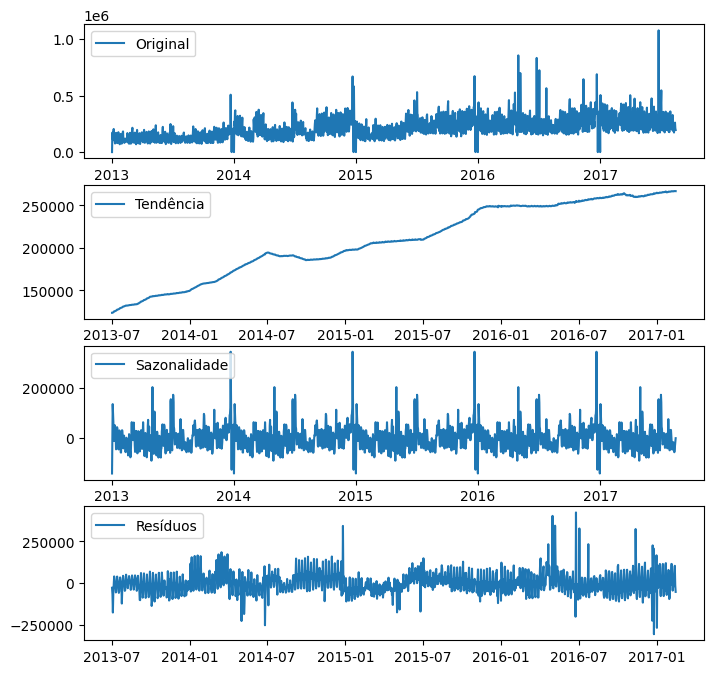

In [125]:
# Decomposição da série temporal para identificar tendências, sazonalidades e resíduos
decomposition = seasonal_decompose(daily_sales['sales'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualização da decomposição
plt.figure(figsize=(8, 8))
plt.subplot(411)
plt.plot(daily_sales['sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Resíduos')
plt.legend(loc='upper left')
plt.show()

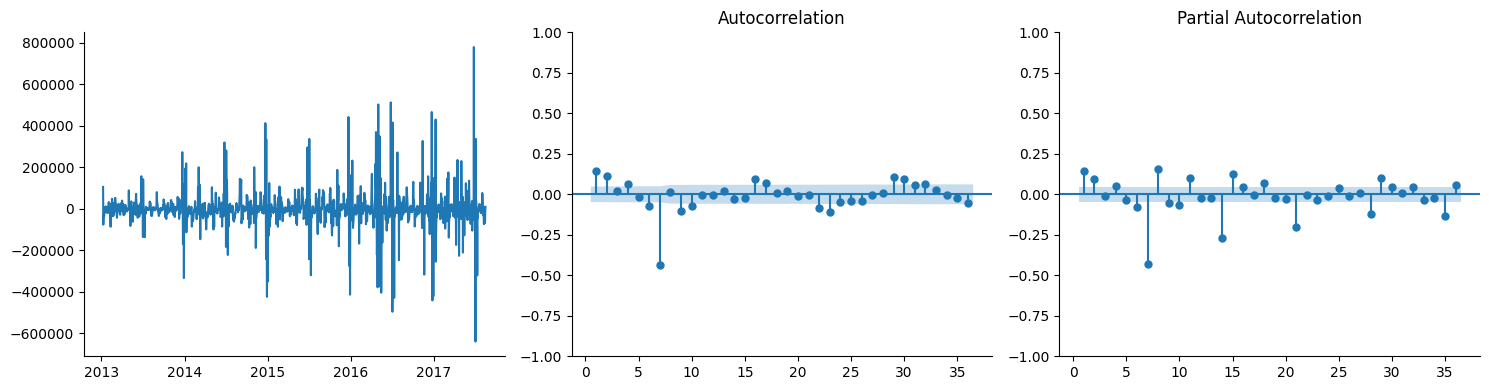

In [126]:
daily_sales['weekly_diff'] = daily_sales['sales'].diff(7)
plots(daily_sales.weekly_diff.dropna(), lags=36);

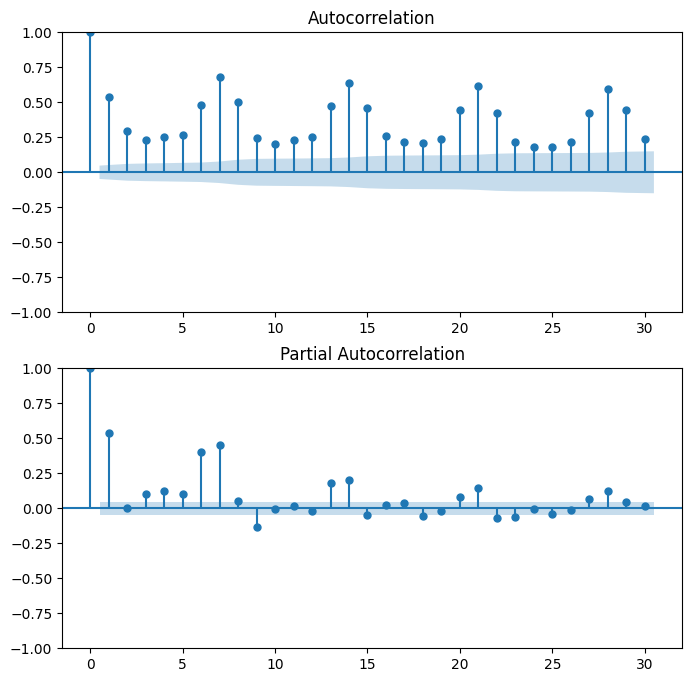

In [127]:
# Gráficos de Autocorrelação (ACF) e Autocorrelação Parcial (PACF)
plt.figure(figsize=(8, 8))
plt.subplot(211)
plot_acf(daily_sales['sales'], ax=plt.gca(), lags=30)
plt.subplot(212)
plot_pacf(daily_sales['sales'], ax=plt.gca(), lags=30)
plt.show()

In [128]:
# Teste de Estacionariedade (ADF Test)
result = adfuller(daily_sales['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.9824155234326186
p-value: 0.03656952173992535
Critical Values:
   1%: -3.434283579780684
   5%: -2.863277451883613
   10%: -2.5676949772294817


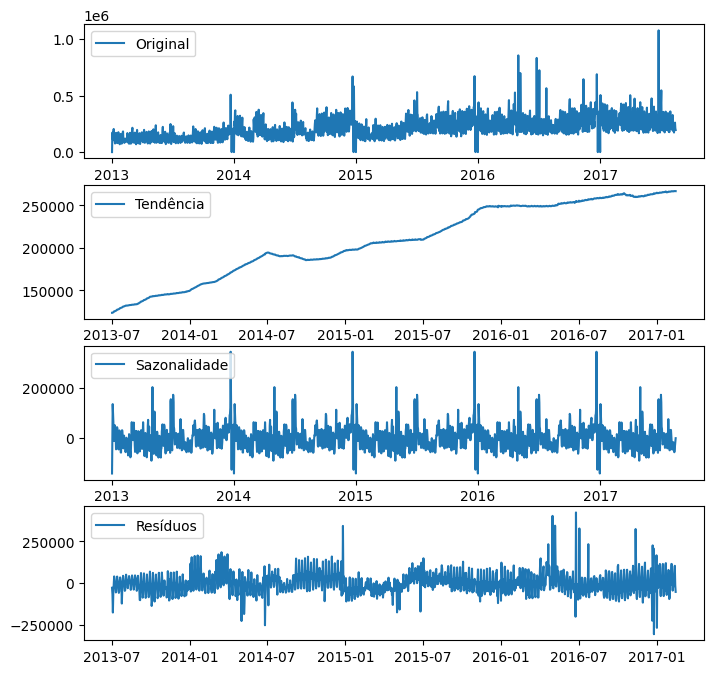

In [129]:
# Decomposição da série temporal para identificar tendências, sazonalidades e resíduos
decomposition = seasonal_decompose(daily_sales['sales'], model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualização da decomposição
plt.figure(figsize=(8, 8))
plt.subplot(411)
plt.plot(daily_sales['sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Resíduos')
plt.legend(loc='upper left')
plt.show()

In [130]:
dftest(daily_sales.weekly_diff.dropna())

Test Statistic         -1.231014e+01
p-value                 7.122499e-23
Lags Used               2.000000e+01
Observations Used       1.660000e+03
Critical Value (1%)    -3.434295e+00
Critical Value (5%)    -2.863283e+00
Critical Value (10%)   -2.567698e+00
dtype: float64


In [131]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(daily_sales['sales'], exog=daily_sales[['holiday', 'onpromotion', 'oil_price']],
                            start_p=2, start_q=0, max_p=3, max_q=2, m=7, # p,q = 1, 2, 3
                           start_P=0, seasonal=True, d=0, D=1, trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=42565.277, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=42191.875, Time=0.85 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=41927.690, Time=1.09 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=42563.332, Time=0.09 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=42538.723, Time=0.29 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=41916.153, Time=3.96 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=41925.792, Time=6.31 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=41988.263, Time=1.55 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=6.28 sec
 ARIMA(0,0,2)(0,1,2)[7] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=inf, Time=7.59 sec
 ARIMA(0,0,1)(0,1,2)[7]             : AIC=41921.305, Ti

In [132]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (0, 0, 1)
seasonal order:  (0, 1, 2, 7)


In [133]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit SARIMA based on helper plots
sar = SARIMAX(daily_sales['sales'],
              exog=daily_sales[['holiday', 'onpromotion', 'oil_price']], #Exclude  'transactions'
                order=order,
                seasonal_order=seasonal_order, #(P, Q, D)
                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  sales   No. Observations:                 1688
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood              -20604.038
Date:                                Tue, 09 Apr 2024   AIC                          41224.076
Time:                                        21:03:19   BIC                          41267.493
Sample:                                    01-01-2013   HQIC                         41240.158
                                         - 08-15-2017                                         
Covariance Type:                                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    -382.6923    598.406     -0.640      0.522   -1555.546     790.161
holiday      2.692e+04   3920.097      6.868      0.000    1.92e+04    3.46e+04
onpromotion   106.6560      2.197     48.555      0.000     102.351     110.961
oil_price    -346.7847    373.517     -0.928      0.353   -1078.864     385.295
ma.L1           0.3301      0.022     14.777      0.000       0.286       0.374
ma.S.L7        -0.7330      0.026    -28.317      0.000      -0.784      -0.682
ma.S.L14       -0.0646      0.028     -2.268      0.023      -0.120      -0.009
sigma2       3.655e+09      0.050   7.29e+10      0.000    3.65e+09    3.65e+09
===================================================================================
Ljung-Box (L1) (Q):                   8.34   Jarque-Bera (JB):              8149.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+26. Standard errors may be unstable.
"""

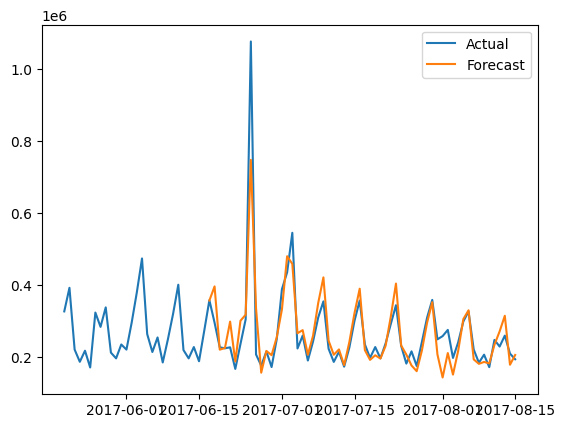

In [134]:
# Select the last 90 days of data for comparison
last_90_days = daily_sales.iloc[-60:]

# Extract the exogenous variables for the last 60 days
exog_data = last_90_days[['holiday', 'onpromotion', 'oil_price']]

# Get the forecast for the next 60 days, including exogenous variables
forecast = sar.get_prediction(start=last_90_days.index[0], end=last_90_days.index[-1], exog=exog_data)

# Extract the predicted values for the next 60 days
predicted_values = forecast.predicted_mean

# Plot the actual sales and predicted values
plt.plot(daily_sales[1600:]['sales'], label = 'Actual')
plt.plot(predicted_values.index, predicted_values, label='Forecast')
plt.legend()
plt.show()